In [ ]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss


import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install iterative-stratification

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.6MB/s 


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
import os
import gc
import random
import math
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import category_encoders as ce

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_logger(filename='log'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
train_targets_nonscored = pd.read_csv('train_targets_nonscored.csv')
train_features = pd.read_csv('train_features.csv')
train_targets = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')
train_drug = pd.read_csv('train_drug.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
submission = pd.read_csv('sample_submission.csv')

cols = [c for c in submission.columns.values if c != 'sig_id']

def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 1, 48: 2, 72: 3})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 2})
    return df

train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
target_cols = [c for c in train_targets_scored.columns if c not in ['sig_id']]

test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

In [ ]:
# add drug id
train = train.merge(train_drug, on='sig_id', how='left')

In [ ]:
le = LabelEncoder()
train['drug_id'] = le.fit_transform(train['drug_id'])

In [ ]:
cat_features = ['cp_time', 'cp_dose']
num_features = [c for c in train.columns if train.dtypes[c] != 'object']
num_features = [c for c in num_features if c not in cat_features]
num_features = [c for c in num_features if c not in target_cols]
target = train[target_cols].values

train = cate2num(train)
test = cate2num(test)

In [ ]:
cat_features = ['cp_time', 'cp_dose']
train = train.drop(columns=['cp_type'])
train.head()

,sig_id,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,...,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680,g-681,g-682,g-683,g-684,g-685,g-686,g-687,g-688,g-689,g-690,g-691,g-692,g-693,g-694,g-695,g-696,g-697,g-698,g-699,g-700,g-701,g-702,g-703,g-704,g-705,g-706,g-707,g-708,g-709,g-710,g-711,g-712,g-713,g-714,g-715,g-716,g-717,g-718,g-719,g-720,g-721,g-722,g-723,g-724,g-725,g-726,g-727,g-728,g-729,g-730,g-731,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-

In [ ]:
cat_features

['cp_time', 'cp_dose']

# Binary CLF

In [ ]:
drug_target = train_targets_scored.merge(train_drug, on='sig_id')
drug_target['sum_drug_by_row'] = drug_target[target_cols].sum(axis=1)
drug_target['sum_drug_by_row_01'] = np.where(drug_target.sum_drug_by_row > 0, 1,0)

train_clf = train_features.merge(drug_target[['sig_id','sum_drug_by_row_01']], on='sig_id', how='left')
target_cols_clf = ['sum_drug_by_row_01']

In [ ]:
train_clf = train_clf[train_clf['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test_clf = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

cat_features = ['cp_time', 'cp_dose']
num_features = [c for c in train_clf.columns if train_clf.dtypes[c] != 'object']
num_features = [c for c in num_features if c not in cat_features]
num_features = [c for c in num_features if c not in target_cols_clf]

target_clf = train_clf['sum_drug_by_row_01'].values
train_clf = cate2num(train_clf)

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

X_train, X_test, Y_train, Y_test = train_test_split(train_clf.drop(columns=['sig_id','cp_type',
                                                        'sum_drug_by_row_01']), target_clf,
                                                    shuffle=True, test_size=.1,
                                                    random_state=12)

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.01, num_leaves=44,
                         n_jobs = -1, importance_type='gain')
clf.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100,
        early_stopping_rounds = 30)

Training until validation scores don't improve for 30 rounds.
[100]	training's binary_logloss: 0.580204	valid_1's binary_logloss: 0.60887
[200]	training's binary_logloss: 0.541158	valid_1's binary_logloss: 0.599887
[300]	training's binary_logloss: 0.509475	valid_1's binary_logloss: 0.596764
[400]	training's binary_logloss: 0.481692	valid_1's binary_logloss: 0.595123
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.475212	valid_1's binary_logloss: 0.595007


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='gain', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=5000, n_jobs=-1, num_leaves=44, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = clf.predict(test_clf.drop(columns=['sig_id','cp_type']))

In [ ]:
test_clf['drug_clf'] = y_pred

# CV

In [ ]:
train_ = train.merge(drug_target[['sig_id','sum_drug_by_row_01']], on='sig_id', how='left')
train_ = train_[train_['sum_drug_by_row_01'] == 1]

In [ ]:
train_ = train_.drop(columns=['sig_id','cp_type','sum_drug_by_row_01'])
train_ = train_.reset_index(drop=True)
X_test = test_clf[test_clf['drug_clf'] ==1]
X_test = X_test.drop(columns=['drug_clf','sig_id','cp_type'])
X_test = X_test.reset_index(drop=True)

# Multilabel KFold

<Figure size 864x864 with 0 Axes>

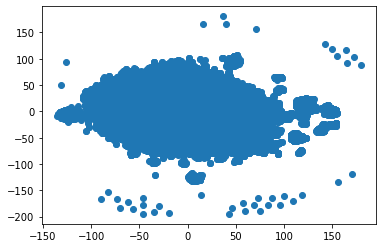

<Figure size 864x864 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_sc = scaler.fit_transform(train.drop(columns=np.append(['sig_id','cp_time','cp_dose'],target_cols)))

tsne = TSNE(random_state=17, perplexity=20.0, early_exaggeration=12.0,
            learning_rate=70.0, n_iter=7000, n_iter_without_progress=300,
            min_grad_norm=1e-07)

tsne_representation = tsne.fit_transform(train.drop(columns=(np.append(['sig_id','cp_time','cp_dose','drug_id'], target_cols))))

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])
plt.figure(figsize=(12, 12))

In [ ]:
# drop columns .05 quantile set 0
tar_05_q = ['antiarrhythmic', 'atm_kinase_inhibitor',
       'atp-sensitive_potassium_channel_antagonist',
       'autotaxin_inhibitor', 'calcineurin_inhibitor',
       'coagulation_factor_inhibitor', 'diuretic', 'elastase_inhibitor',
       'erbb2_inhibitor', 'laxative', 'leukotriene_inhibitor',
       'lxr_agonist', 'nicotinic_receptor_agonist',
       'protein_phosphatase_inhibitor', 'retinoid_receptor_antagonist',
       'steroid', 'tropomyosin_receptor_kinase_inhibitor',
       'ubiquitin_specific_protease_inhibitor']

In [ ]:
# train.drop(columns=(np.append(['sig_id','cp_time','cp_dose'], target_cols)))
train = train.drop(columns=tar_05_q)

In [ ]:
# train['cl1'] = tsne_representation[:, 0]
# train['cl2'] =tsne_representation[:, 1]

In [ ]:
target_cols = list(set(target_cols) - set(tar_05_q))

In [ ]:
num_features

In [ ]:
num_features.remove('cp_dose')
num_features.remove('cp_time')#, '')

In [ ]:
cat_features#.append('drug_id')

['cp_time', 'cp_dose']

In [ ]:
train = train.sort_values(by='sig_id', ascending=True)
folds = train.drop(columns=['sig_id']).copy()
Fold = MultilabelStratifiedKFold(n_splits=5, shuffle=False, random_state=17)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[target_cols])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.shape)

(21948, 1064)


# Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, num_features, cat_features, labels):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values
        self.labels = labels
        
    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])
        label = torch.tensor(self.labels[idx]).float()
        
        return cont_x, cate_x, label
    

class TestDataset(Dataset):
    def __init__(self, df, num_features, cat_features):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values
        
    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])
        
        return cont_x, cate_x

# MODEL

In [ ]:
class CFG:
    max_grad_norm=1000
    gradient_accumulation_steps=1
    hidden_size=512
    dropout=0.5
    lr=1e-2
    weight_decay=1e-6
    batch_size=32
    epochs=30
    #total_cate_size=5
    #emb_size=4
    num_features=num_features
    cat_features=cat_features
    target_cols=target_cols

In [ ]:
class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(len(cfg.num_features), cfg.hidden_size),
                          nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.PReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.PReLU(),
                          nn.Linear(cfg.hidden_size, len(cfg.target_cols)),
                          )

    def forward(self, cont_x, cate_x):
        # no use of cate_x yet
        x = self.mlp(cont_x)
        return x


In [ ]:
def train_fn(train_loader, model, optimizer, epoch, scheduler, device):
    
    losses = AverageMeter()

    model.train()

    for step, (cont_x, cate_x, y) in enumerate(train_loader):
        
        cont_x, cate_x, y = cont_x.to(device), cate_x.to(device), y.to(device)
        batch_size = cont_x.size(0)

        pred = model(cont_x, cate_x)
        
        loss = nn.BCEWithLogitsLoss()(pred, y)
        losses.update(loss.item(), batch_size)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        loss.backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)

        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
        
    return losses.avg


def validate_fn(valid_loader, model, device):
    
    losses = AverageMeter()

    model.eval()
    val_preds = []

    for step, (cont_x, cate_x, y) in enumerate(valid_loader):
        
        cont_x, cate_x, y = cont_x.to(device), cate_x.to(device), y.to(device)
        batch_size = cont_x.size(0)

        with torch.no_grad():
            pred = model(cont_x, cate_x)
            
        loss = nn.BCEWithLogitsLoss()(pred, y)
        losses.update(loss.item(), batch_size)

        val_preds.append(pred.sigmoid().detach().cpu().numpy())

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

    val_preds = np.concatenate(val_preds)
        
    return losses.avg, val_preds


def inference_fn(test_loader, model, device):

    model.eval()
    preds = []

    for step, (cont_x, cate_x) in enumerate(test_loader):

        cont_x,  cate_x = cont_x.to(device), cate_x.to(device)

        with torch.no_grad():
            pred = model(cont_x, cate_x)

        preds.append(pred.sigmoid().detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def run_single_nn(cfg, train, test, folds, num_features, cat_features, target, device, fold_num=0, seed=42):
    
    # Set seed
    logger.info(f'Set seed {seed}')
    seed_everything(seed=seed)

    # loader
    trn_idx = folds[folds['fold'] != fold_num].index
    val_idx = folds[folds['fold'] == fold_num].index
    train_folds = train.loc[trn_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].reset_index(drop=True)
    train_target = target[trn_idx]
    valid_target = target[val_idx]
    train_dataset = TrainDataset(train_folds, num_features, cat_features, train_target)
    valid_dataset = TrainDataset(valid_folds, num_features, cat_features, valid_target)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, 
                              num_workers=4, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=False, 
                              num_workers=4, pin_memory=True, drop_last=False)

    # model
    model = TabularNN(cfg)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-1,\
                                              epochs=cfg.epochs, steps_per_epoch=len(train_loader))
    # log
    log_df = pd.DataFrame(columns=(['EPOCH']+['TRAIN_LOSS']+['VALID_LOSS']) )

    # train & validate
    best_loss = np.inf
    for epoch in range(cfg.epochs):
        train_loss = train_fn(train_loader, model, optimizer, epoch, scheduler, device)
        valid_loss, val_preds = validate_fn(valid_loader, model, device)
        log_row = {'EPOCH': epoch, 
                   'TRAIN_LOSS': train_loss,
                   'VALID_LOSS': valid_loss,
                  }
        log_df = log_df.append(pd.DataFrame(log_row, index=[0]), sort=False)
        #logger.info(log_df.tail(1))
        if valid_loss < best_loss:
            logger.info(f'epoch{epoch} save best model... {valid_loss}')
            best_loss = valid_loss
            oof = np.zeros((len(train), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_seed{seed}.pth")

    # predictions
    #test_dataset = TestDataset(test, num_features, cat_features)
    #test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, 
    #                         num_workers=4, pin_memory=True)
    model = TabularNN(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_seed{seed}.pth"))
    model.to(device)
    #predictions = inference_fn(test_loader, model, device)
    
    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, train, test, folds, num_features, cat_features, target, device, n_fold=5, seed=42):

    oof = np.zeros((len(train), len(cfg.target_cols)))
    predictions = np.zeros((len(test), len(cfg.target_cols)))

    for _fold in range(n_fold):
        logger.info("Fold {}".format(_fold))
        _oof, _predictions = run_single_nn(cfg,
                                           train,
                                           test,
                                           folds,
                                           num_features, 
                                           cat_features,
                                           target, 
                                           device,
                                           fold_num=_fold,
                                           seed=seed)
        oof += _oof
        predictions += _predictions / n_fold

    score = 0
    for i in range(target.shape[1]):
        _score = log_loss(target[:,i], oof[:,i])
        score += _score / target.shape[1]
    logger.info(f"CV score: {score}")
    
    return oof, predictions

# train Model

In [ ]:
# Seed Averaging for solid result
oof = np.zeros((len(train), len(CFG.target_cols)))
predictions = np.zeros((len(test), len(CFG.target_cols)))

SEED = [0, 1, 2]
for seed in SEED:
    _oof, _predictions = run_kfold_nn(CFG, 
                                      train.drop(columns=target_cols), test, folds, 
                                      num_features, cat_features, train[target_cols].values,
                                      device,
                                      n_fold=5, seed=seed)
    oof += _oof / len(SEED)
    predictions += _predictions / len(SEED)


Fold 0
Set seed 0
epoch0 save best model... 0.022253885403580982
epoch24 save best model... 0.020988419742783815
epoch25 save best model... 0.020298910256398836
epoch26 save best model... 0.019856808150445954
epoch27 save best model... 0.019387417107158616
epoch28 save best model... 0.01910762715074902
Fold 1
Set seed 0
epoch0 save best model... 0.022804060338905745
epoch20 save best model... 0.022700772576388858
epoch21 save best model... 0.02242834491990074
epoch22 save best model... 0.022161038741842845
epoch23 save best model... 0.021151789765160783
epoch24 save best model... 0.020602789372850806
epoch25 save best model... 0.019880982862365736
epoch26 save best model... 0.019424587054872842
epoch27 save best model... 0.01901858617159277
epoch28 save best model... 0.018823227838978704
epoch29 save best model... 0.018759272576709302
Fold 2
Set seed 0
epoch0 save best model... 0.023340661265804582
epoch1 save best model... 0.023107321427154923
epoch20 save best model... 0.022868491744

In [ ]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
target_cols = list((set(target_cols) -  set(tar_05_q)))
target = train[target_cols].values

In [ ]:
from sklearn.metrics import roc_auc_score
# Final result with 'cp_type'=='ctl_vehicle' data
train[target_cols] = oof

score = 0
for i in range(target.shape[1]):
    _score = log_loss(target[:,i], oof[:,i])
    score += _score / target.shape[1]
print(f"Seed Averaged CV score: {score}")

from sklearn.metrics import roc_auc_score

aucs = []
for i in range(target.shape[1]):
    aucs.append(roc_auc_score(y_true=target[:, i],
                              y_score=oof[:, i]))
print(f"Overall AUC : {np.mean(aucs)}")
print(f"Average CV : {np.mean(score)}")

In [ ]:
from sklearn.metrics import roc_auc_score
# Final result with 'cp_type'=='ctl_vehicle' data
train[target_cols] = oof
train[tar_05_q] = 0

test[target_cols] = predictions
test[tar_05_q] = 0

target_cols = target_cols + tar_05_q


result = train_targets_scored.drop(columns=target_cols)\
            .merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
y_true = train_targets_scored[target_cols].values
y_pred = result[target_cols].values
score = 0
for i in range(y_true.shape[1]):
    _score = log_loss(y_true[:,i], y_pred[:,i])
    score += _score / y_true.shape[1]
logger.info(f"Final result: {score}")


In [ ]:
train_pred = train.merge(drug_target[['sig_id','sum_drug_by_row_01']], on='sig_id', how='left')
train_pred = train_pred[train_pred['sum_drug_by_row_01']==1]
train_pred[target_cols]=oof
train_sub = train_targets_scored.drop(columns=target_cols).merge(train_pred[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = train_sub[target_cols].values
score = 0
for i in range(y_true.shape[1]):
    _score = log_loss(y_true[:,i], y_pred[:,i])
    score += _score / y_true.shape[1]
print(f"Final result: {score}")

Final result: 0.014744071884041587


In [ ]:
from sklearn.metrics import roc_auc_score

aucs = []
for i in range(y_true.shape[1]):
    aucs.append(roc_auc_score(y_true=y_true[:, i],
                              y_score=y_pred[:, i]))
print(f"Overall AUC : {np.mean(aucs)}")
print(f"Average CV : {np.mean(score)}")

Overall AUC : 0.8319421616316526
Average CV : 0.014744071884041587


In [ ]:
test_pred = test_clf[test_clf['drug_clf'] ==1].copy()
test_pred[target_cols]=predictions.mean(axis=0)

In [ ]:
sub = submission.drop(columns=target_cols).merge(test_pred[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhib